In [1]:
%matplotlib inline

import os
import time
import copy
import pickle
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import h5py
from tqdm.auto import tqdm, trange
import umap
from sampler import ImbalancedDatasetSampler
from ood_metrics import auroc, plot_roc, plot_barcode, calc_metrics, detection_error, fpr_at_95_tpr
import mc_uncertainty as mc

import torch
from torch.nn import functional as F
from torchvision import transforms
import torchvision.models as models
from torchvision.datasets import CIFAR10, CIFAR100, ImageFolder, SVHN
from torch import nn, optim
import torch.utils.data
import torchvision

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve


CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
FG_CLASSES = list(map(CIFAR10_CLASSES.index, 
                 ["automobile"]))
BG_CLASSES = list(map(CIFAR10_CLASSES.index, 
                 ["airplane", "cat", "bird", "deer", "frog", "dog", "horse", "ship", "truck"]))

NUM_CLASSES = 10
# INPUT_SIZE = 224
INPUT_SIZE = 32
BATCH_SIZE = 128
NUM_FEATURE_LAYERS = 31

RESULTS_FILE = 'mahal_llr.h5'

TRAIN = False

In [2]:
def create_model(kind='resnet152'):
    # Download pretrained model
    if kind == 'resnet152':
        model = models.resnet152(pretrained=True)
    elif kind == "densenet161":
        model = models.densenet161(pretrained=True)
    elif kind == "vgg16":
        model = models.vgg16(pretrained=True)
        
    # Freeze weights
    for param in model.parameters():
        param.requires_grad = False

    # Re-implement final classification layer
    if kind == 'resnet152':
        model.fc = nn.Linear(in_features=model.fc.in_features, out_features=NUM_CLASSES, bias=True)
    elif kind == "densenet161":
        model.classifier = nn.Linear(in_features=model.classifier.in_features, out_features=NUM_CLASSES, bias=True)
    elif kind == "vgg16":
        model.classifier[6] = nn.Linear(in_features=model.classifier[6].in_features, out_features=NUM_CLASSES, bias=True)

    return model


class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    """

    def __init__(self, dataset, indices=None, num_samples=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices
            
        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        return dataset.target_transform(dataset.targets[idx])
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples
        


def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, lr_scheduler=None, train_phase_name='train', val_phase_name='val'):
    since = time.time()

    train_acc_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in trange(num_epochs, desc="Epochs"):
        tqdm.write('Epoch {}/{}'.format(epoch, num_epochs - 1))
        tqdm.write('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in [train_phase_name, val_phase_name]:
            if phase == train_phase_name:
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], 
                                       total=len(dataloaders[phase]), 
                                       desc="{} batches".format(phase),
                                       leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == train_phase_name):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == train_phase_name:
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            tqdm.write('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == val_phase_name and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == val_phase_name:
                val_loss = epoch_loss
                val_acc_history.append(epoch_acc)
            elif phase == train_phase_name:
                train_acc_history.append(epoch_acc)
                
        if lr_scheduler is not None:
            lr_scheduler.step(val_loss)
            
        tqdm.write("\n")

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history


def save_model(model, path='model.pt'):
    torch.save(model.state_dict(), path)

    
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()


def plot_training_hist(train_hist, val_hist):
    thist = []
    vhist = []

    thist = [h.cpu().numpy() for h in train_hist]
    vhist = [h.cpu().numpy() for h in val_hist]

    plt.title("Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy")
    plt.plot(range(1,NUM_EPOCHS+1),thist,label="Train")
    plt.plot(range(1,NUM_EPOCHS+1),vhist,label="Val")
    plt.legend()
    plt.show()
    
    
def save_history(train_hist, val_hist, train_hist_path='train_hist.pickle', val_hist_path='val_hist.pickle'):
    with open(train_hist_path, 'wb') as f:
        pickle.dump(train_hist, f)
    with open(val_hist_path, 'wb') as f:
        pickle.dump(val_hist, f)
        
        
def load_history(train_hist_path='train_hist.pickle', val_hist_path='val_hist.pickle'):
    with open(train_hist_path, 'rb') as f:
        train_hist = pickle.load(f)
    with open(val_hist_path, 'rb') as f:
        val_hist = pickle.load(f)
    return train_hist, val_hist


def evaluate_model(model, dataloader):
    running_corrects = 0
    
    for inputs, labels in tqdm(dataloader, total=len(dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

        # statistics
        running_corrects += torch.sum(preds == labels.data)

    accuracy = running_corrects.double() / len(dataloader.dataset)
    return accuracy.detach().cpu().item()

# Implement a pretrained classifer and finetuning for CIFAR 10

## Set up data loaders

In [3]:
# Set up data loaders
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.RandomResizedCrop(INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

def label_transform(y):
    if y in FG_CLASSES: return 0
    elif y in BG_CLASSES: return 1
    else: return 2

cifar10_train = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar10/', train=True, transform=data_transforms['train'])
cifar10_train_no_aug = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar10/', train=True, transform=data_transforms['val'])
cifar10_test = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar10/', train=False, transform=data_transforms['val'])

cifar100_ood = CIFAR100('/media/tadenoud/DATADisk/datasets/cifar100/', train=False, transform=data_transforms['val'],
                       target_transform=lambda y: y+NUM_CLASSES)
imagenet_resize = ImageFolder('/media/tadenoud/DATADisk/datasets/tiny-imagenet-200/test', transform=data_transforms['val'],
                             target_transform=lambda y: y+NUM_CLASSES)
svhn_ood = SVHN('/media/tadenoud/DATADisk/datasets/svhn', split='test', transform=data_transforms['val'],
                target_transform=lambda y: y+NUM_CLASSES)


dataloaders_dict = {
    'train': torch.utils.data.DataLoader(cifar10_train, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True),
    'train_no_aug': torch.utils.data.DataLoader(cifar10_train_no_aug, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(cifar10_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
    'ood': torch.utils.data.DataLoader(cifar100_ood, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
    'imagenet_resize': torch.utils.data.DataLoader(imagenet_resize, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
    'svhn': torch.utils.data.DataLoader(svhn_ood, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
model = create_model("vgg16")
model = model.to(device)

## Define optimization objective, optimizer, etc

In [5]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, patience=5)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


## Train and evaluate

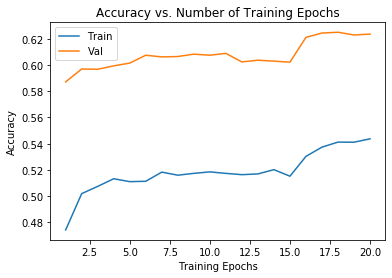

In [6]:
NUM_EPOCHS = 20
if TRAIN:
    # Train and evaluate
    model, val_hist, train_hist = train_model(
        model, 
        dataloaders_dict, 
        criterion, 
        optimizer_ft, 
        num_epochs=NUM_EPOCHS,
        lr_scheduler=scheduler_ft)
    save_model(model, path='mahal_llr_1.pt')
    save_history(train_hist, val_hist, 'mahal_llr_1_train_hist.pickle', 'mahal_llr_1_val_hist.pickle')
else:
    load_model(model, path='mahal_llr_1.pt')
    train_hist, val_hist = load_history('mahal_llr_1_train_hist.pickle', 'mahal_llr_1_val_hist.pickle')

plot_training_hist(train_hist, val_hist)    

## Fine tune top convolutional layers

In [7]:
# print(model)

# Freeze weights
for param in model.parameters():
    param.requires_grad = False
    
# Unfreeze top layers
for param in model.features[23:].parameters():
    param.requires_grad = True
    
for param in model.classifier.parameters():
    param.requires_grad = True

In [8]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=1e-3, momentum=0.9)
scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, patience=5)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 features.24.weight
	 features.24.bias
	 features.26.weight
	 features.26.bias
	 features.28.weight
	 features.28.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


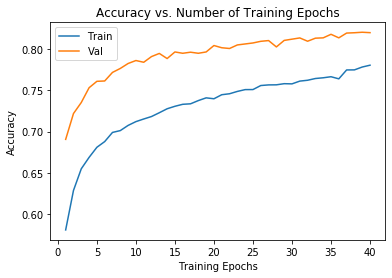

In [9]:
NUM_EPOCHS = 40
if TRAIN:
    # Train and evaluate
    model, val_hist, train_hist = train_model(model, 
                                              dataloaders_dict, 
                                              criterion, 
                                              optimizer_ft, 
                                              num_epochs=NUM_EPOCHS,
                                              lr_scheduler=scheduler_ft)
    save_model(model, path='mahal_llr_1_fine.pt')
    save_history(train_hist, val_hist, 'mahal_llr_1_train_hist_fine.pickle', 'mahal_llr_1_val_hist_fine.pickle')
else:
    load_model(model, path='mahal_llr_1_fine.pt')
    train_hist, val_hist = load_history('mahal_llr_1_train_hist_fine.pickle', 'mahal_llr_1_val_hist_fine.pickle')

plot_training_hist(train_hist, val_hist)

In [10]:
print("Model accuracy:", evaluate_model(model, dataloaders_dict['val'])) 


Model accuracy: 0.8204


# Train a second classifer with input corruption

## Set up data loaders

In [11]:
from torch import distributions
torch.manual_seed(42)
from PIL import Image

BERNOULLI_MU = 0.2
IMG_SHAPE = (32, 32, 3)

    
class BernoulliPixelSwap(object):
    """
    Draws img_size samples from a Bernoulli distribution parameterized by mu.
    For each positive sample drawn, the corresponding pixel in the image the function
    is called on will be randomly assigned a value in [0,255] with equal probability.
    """
    def __init__(self, mu, img_shape):
        super().__init__()
        self.img_shape = img_shape
        self.bernoulli = distributions.Bernoulli(mu)
        self.multinomial = distributions.categorical.Categorical(torch.Tensor(list(range(256))))
        
    def __call__(self, img):
        mask = self.bernoulli.sample(self.img_shape).numpy().astype(np.bool)        
        values = self.multinomial.sample(self.img_shape).numpy()
        
        new_img = np.asarray(img).copy()
        new_img[mask] = values[mask]
        return Image.fromarray(new_img)
                                  
bernoulli_swap = BernoulliPixelSwap(BERNOULLI_MU, IMG_SHAPE)

In [12]:
# Set up data loaders
data_transforms['train_corruption'] = transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.RandomResizedCrop(INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(bernoulli_swap),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

cifar10_train_corruption = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar10/', train=True, transform=data_transforms['train_corruption'])

dataloaders_dict['train_corruption'] = torch.utils.data.DataLoader(cifar10_train_corruption, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)

In [13]:
model = create_model("vgg16")
model = model.to(device)

## Define optimization objective, optimizer, etc

In [14]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, patience=5)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


## Train and evaluate

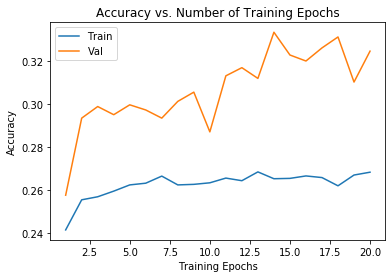

In [15]:
NUM_EPOCHS = 20
if TRAIN:
    # Train and evaluate
    model, val_hist, train_hist = train_model(
        model, 
        dataloaders_dict, 
        criterion, 
        optimizer_ft, 
        num_epochs=NUM_EPOCHS,
        lr_scheduler=scheduler_ft,
        train_phase_name='train_corruption'
    )
    save_model(model, path='mahal_llr_2.pt')
    save_history(train_hist, val_hist, 'mahal_llr_2_train_hist.pickle', 'mahal_llr_2_val_hist.pickle')
else:
    load_model(model, path='mahal_llr_2.pt')
    train_hist, val_hist = load_history('mahal_llr_2_train_hist.pickle', 'mahal_llr_2_val_hist.pickle')

plot_training_hist(train_hist, val_hist)    

## Fine tune top convolutional layers

In [16]:
# print(model)

# Freeze weights
for param in model.parameters():
    param.requires_grad = False
    
# Unfreeze top layers
for param in model.features[23:].parameters():
    param.requires_grad = True
    
for param in model.classifier.parameters():
    param.requires_grad = True

In [17]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=1e-3, momentum=0.9)
scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, patience=5)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 features.24.weight
	 features.24.bias
	 features.26.weight
	 features.26.bias
	 features.28.weight
	 features.28.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


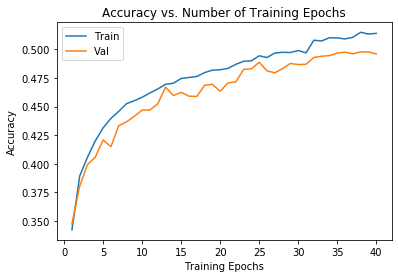

In [18]:
NUM_EPOCHS = 40
if TRAIN:
    # Train and evaluate
    model, val_hist, train_hist = train_model(model, 
                                              dataloaders_dict, 
                                              criterion, 
                                              optimizer_ft, 
                                              num_epochs=NUM_EPOCHS,
                                              lr_scheduler=scheduler_ft,
                                              train_phase_name='train_corruption'
                                             )
    save_model(model, path='mahal_llr_2_fine.pt')
    save_history(train_hist, val_hist, 'mahal_llr_2_train_hist_fine.pickle', 'mahal_llr_2_val_hist_fine.pickle')
else:
    load_model(model, path='mahal_llr_2_fine.pt')
    train_hist, val_hist = load_history('mahal_llr_2_train_hist_fine.pickle', 'mahal_llr_2_val_hist_fine.pickle')

plot_training_hist(train_hist, val_hist)

In [19]:
print("Model accuracy:", evaluate_model(model, dataloaders_dict['val'])) 


Model accuracy: 0.4979


# Train Mahalanobis Distance functions

In [141]:
model1 = create_model("vgg16")
model1 = model1.to(device)
load_model(model1, path="mahal_llr_1_fine.pt")

model2 = create_model("vgg16")
model2 = model2.to(device)
load_model(model2, path="mahal_llr_2_fine.pt")

In [142]:
def penultimate_forward_vgg16(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    
    # Break up self.classifier
    penultimate = model.classifier[:5](x)
    out = model.classifier[5:](penultimate)
    return out, penultimate

# Bind a function to the model to extract penultimate features
model1.penultimate_forward = penultimate_forward_vgg16.__get__(model1)
model2.penultimate_forward = penultimate_forward_vgg16.__get__(model2)

In [143]:
# Get penultimate features, outputs, and labels from datasets set
if TRAIN:
    for model, result_file in [(model1, 'mahal_llr_1.h5'), (model2, 'mahal_llr_2.h5')]:
        model.eval()

        for dataset in ['train_no_aug', 'val', 'ood', 'svhn']:
            softmax_outputs = []
            mahalanobis_features = []
            labels_out = []  

            for inputs, labels in tqdm(dataloaders_dict[dataset], total=len(dataloaders_dict[dataset]), desc=dataset):
                outputs, features = model.penultimate_forward(inputs.to(device))

                softmax_outputs.append(outputs.cpu().detach().numpy())
                mahalanobis_features.append(features.cpu().detach().numpy())
                labels_out.append(labels.cpu().detach().numpy())

            # Save outputs to disk
            with h5py.File(result_file, "a") as f:
                if dataset in f.keys():
                    del f[dataset]

                g = f.create_group(dataset)
                g.create_dataset("softmax_outputs", data=np.concatenate(softmax_outputs, axis=0))
                g.create_dataset("mahalanobis_features", data=np.concatenate(mahalanobis_features, axis=0))
                g.create_dataset("labels", data=np.concatenate(labels_out, axis=0))

In [203]:
class Mahal_Dist(object):
    def __init__(self, gt_features=None, gt_labels=None):
        super().__init__()
        
        if gt_features is not None and gt_labels is not None:
            self.fit(gt_features, gt_labels)
        
    def fit(self, gt_features, gt_labels):
        """Fit parameters used for Mahalanobis distance."""
        self.labels = sorted(np.unique(gt_labels).astype(np.int))
        
        mahal_means = []
        print("Calculating mahal mean")
        for l in self.labels:
            mask = gt_labels == l
            mahal_means.append(gt_features[mask].mean(axis=0))#, dtype=np.float16))
            
        self.mahal_means = np.array(mahal_means)

        x = gt_features.copy()
        print("Calculating mahal cov")
        for i, l in enumerate(self.labels):
            mask = gt_labels == l
            x[mask] -= self.mahal_means[i]

        self.mahal_cov = np.dot(x.T, x) / len(gt_features)
        print("Inverting")
        self.inv_mahal_cov = np.linalg.inv(self.mahal_cov + np.eye(len(self.mahal_cov)) * 1e-10)
        
    def __call__(self, features):
        """Return the distance based confidence score to each 
            of the means."""
        x =  -self.mahal_means + features
        m_x = np.diag(np.dot(np.dot(x, self.inv_mahal_cov), x.T))
        return np.array(m_x)
    
    def label_dist(self, features):
        """Return the label of the closest mean and the 
            mahalanobis distance to it."""
        m_x = self(features)
        min_i = np.argmin(m_x, axis=0)
        return np.array([self.labels[min_i], m_x[min_i]])
    
    def label(self, features):
        """Return the label of the closest mean."""
        return self.labels[np.argmin(self(features), axis=0)]
    
    def dist(self, features):
        """Return the dist of the closest mean."""
        return np.min(self(features), axis=0)
    
    def save(self, fname='mahal_distance.h5'):
        """Save precomputed Mahal_Dist object with all means and covariance matrix."""
        with h5py.File(fname, 'a') as f:
            # Remove old data if exists
            if "mahal_distance" in f.keys():
                del f['mahal_distance']
                
            # Store the new data
            g = f.create_group("mahal_distance")
            g.create_dataset("means", data=self.mahal_means)
            g.create_dataset("cov", data=self.mahal_cov)
            g.create_dataset("inv_cov", data=self.inv_mahal_cov)
            g.create_dataset("labels", data=self.inv_mahal_cov)
            
    @classmethod
    def load(cls, fname='mahal_distance.h5'):
        """Load precomputed Mahal_Dist object with all means and covariance matrix."""
        inst = cls()
        
        with h5py.File(fname, 'r') as f:
            inst.labels = f['mahal_distance/labels'][()]
            inst.mahal_means = f['mahal_distance/means'][()]
            inst.mahal_cov = f['mahal_distance/cov'][()]
            inst.inv_mahal_cov = f['mahal_distance/inv_cov'][()]
        
        return inst

In [206]:
md = []
for i, result_file in enumerate(['mahal_llr_1.h5', 'mahal_llr_2.h5']): 
    if TRAIN:
        with h5py.File(result_file, "r") as f:
            print(f.keys())
            mahalanobis_features_train = f['train_no_aug/mahalanobis_features'][()]
            labels_train = f['train_no_aug/labels'][()]

        md.append(Mahal_Dist())
        md[-1].fit(mahalanobis_features_train, labels_train)
        md[-1].save(result_file)
    else:
        md.append(Mahal_Dist.load(result_file))

# Extract FG, BG, OOD Softmax predictions and Mahal features

In [154]:
for i, result_file in enumerate(['mahal_llr_1.h5', 'mahal_llr_2.h5']): 
    if TRAIN:
        for dataset in ['val', 'ood']:#, 'svhn']:
            with h5py.File(result_file, 'r') as f:
                g = f[dataset]
                labels = g['labels'][()]
                features = g['mahalanobis_features'][()]
                outputs = g['softmax_outputs'][()]    

            mahalanobis_label_dist = []
            for feat in tqdm(features, total=len(features)):
                mahalanobis_label_dist.append(md[i].label_dist(feat))

            # Get gt_labels, predicted labels, distance to nearest mean
            mahalanobis_labels = [x[0] for x in mahalanobis_label_dist]
            mahalanobis_dist = [x[1] for x in mahalanobis_label_dist]

            with h5py.File(result_file, 'a') as f:
                g = f[dataset]          
                g.create_dataset('mahalanobis_labels', data=mahalanobis_labels)
                g.create_dataset('mahalanobis_dists', data=mahalanobis_dist)    

In [155]:
for i, result_file in enumerate(['mahal_llr_1.h5', 'mahal_llr_2.h5']): 
    with h5py.File(result_file, 'r') as f:
        g = f['val']
        labels_val = g['labels'][()]
        mahalanobis_labels_val = g['mahalanobis_labels'][()]
        mahalanobis_dist_val = g['mahalanobis_dists'][()]

    correct = np.sum((mahalanobis_labels_val == labels_val).astype(np.int))
    print("%d%% of val data classified correctly with mahalanobis distance" % (correct / len(labels_val) * 100))

82% of val data classified correctly with mahalanobis distance
69% of val data classified correctly with mahalanobis distance


### Compare naive Mahalanobis distance to LLR Mahalanobis

In [164]:
for i, result_file in enumerate(['mahal_llr_1.h5', 'mahal_llr_2.h5']): 
    print(result_file)
    if TRAIN:
        for dataset in ['val', 'ood', 'svhn', 'imagenet_resize']:
            print(dataset)
            with h5py.File(result_file, 'r') as f:
                g = f[dataset]
                labels = g['labels'][()]
                features = g['mahalanobis_features'][()]
                outputs = g['softmax_outputs'][()]    

            # Get dists to each class
            mahalanobis_dists = []
            for feat in tqdm(features, total=len(features)):
                mahalanobis_dists.append(md[i](feat))

            with h5py.File(result_file, 'a') as f:
                g = f[dataset]          
                g.create_dataset('mahalanobis_all_dists', data=mahalanobis_dists) 

mahal_llr_1.h5
svhn


mahal_llr_2.h5
svhn


In [253]:
OOD_SET = 'ood'

with h5py.File('mahal_llr_1.h5', 'r') as f:          
    d1_val = f['val/mahalanobis_all_dists'][()]
    d1_ood = f[f'{OOD_SET}/mahalanobis_all_dists'][()]
    
with h5py.File('mahal_llr_2.h5', 'r') as f:          
    d2_val = f['val/mahalanobis_all_dists'][()]
    d2_ood = f[f'{OOD_SET}/mahalanobis_all_dists'][()]
    
with h5py.File('mahal_llr_1.h5', 'r') as f:          
    labels_val = f['val/labels'][()]
    labels_ood = f[f'{OOD_SET}/labels'][()]
    
def llr(d1, d2):
    d1 = np.array(d1)
    d2 = np.array(d2)
    
    # Get most likely class distance using d1 classifier
    ii = d1.argmin(axis=1)
    
    # LLR = - ll1_dists + ll2_dists
    return (d1.take(ii) - d2.take(ii))

llr_val = llr(d1_val, d2_val)
llr_ood = llr(d1_ood, d2_ood)

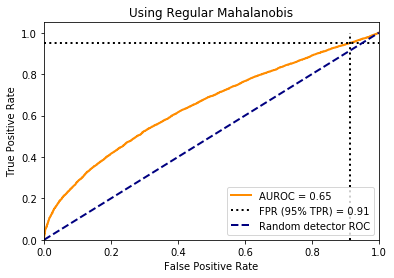

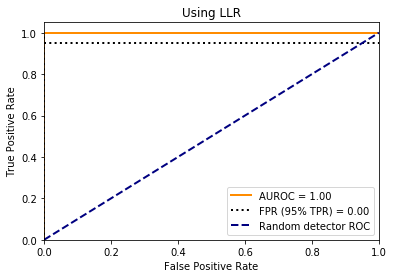

In [254]:
from ood_metrics import plot_roc

llr = abs(np.concatenate([llr_val, llr_ood], axis=0))
labels = np.concatenate([labels_val, labels_ood], axis=0)
labels[labels < 10] = 0
labels[labels >= 10] = 1

naive_scores = np.concatenate([d1_val.max(axis=1), d1_ood.max(axis=1)], axis=0)

plot_roc(naive_scores, labels, title="Using Regular Mahalanobis")
plot_roc(llr, labels, title="Using LLR")

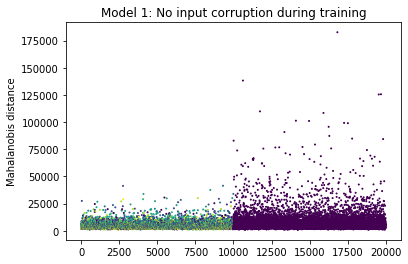

In [255]:
labels = np.concatenate([labels_val, labels_ood], axis=0)
labels[labels >= 10] = 0

plt.scatter(range(len(naive_scores)), naive_scores, c=labels, s=1)
plt.title("Model 1: No input corruption during training")
plt.ylabel("Mahalanobis distance")
plt.show()

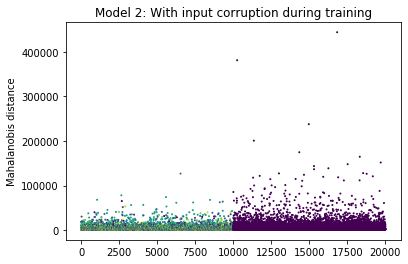

In [256]:
other_scores = np.concatenate([d2_val.max(axis=1), d2_ood.max(axis=1)], axis=0)
plt.scatter(range(len(other_scores)), other_scores, c=labels, s=1)
plt.title("Model 2: With input corruption during training")
plt.ylabel("Mahalanobis distance")
plt.show()

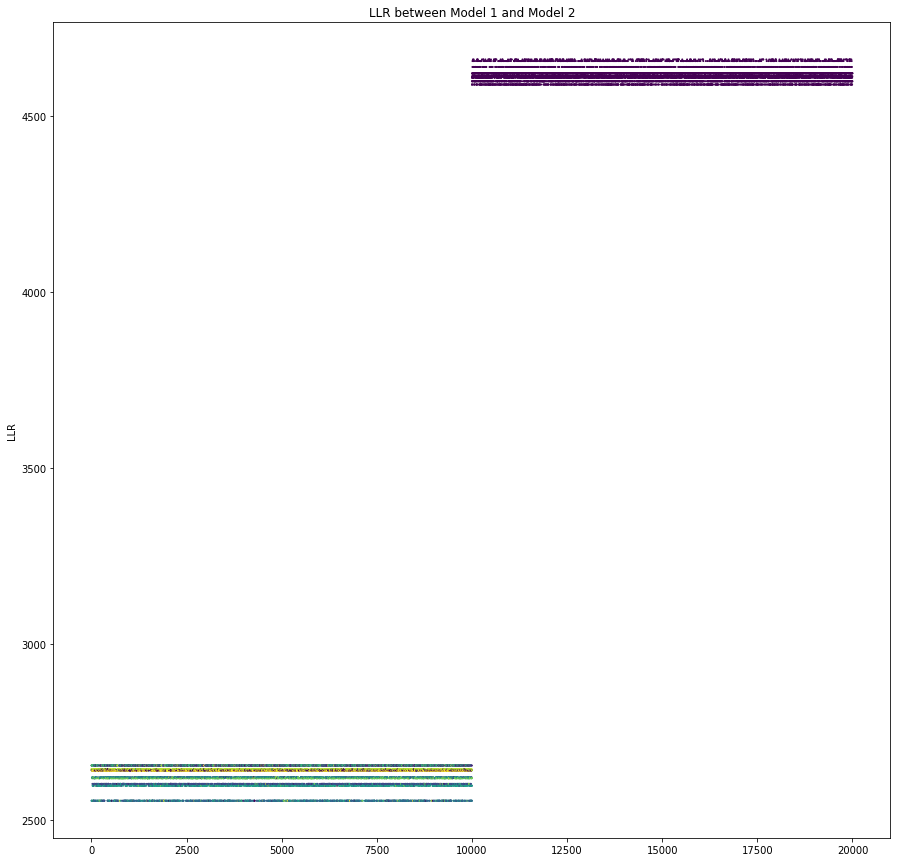

In [269]:
plt.figure(figsize=(15,15))
plt.scatter(range(len(llr)), llr, c=labels, s=1)
plt.title("LLR between Model 1 and Model 2")
plt.ylabel("LLR")
plt.show()

# Separating BG+FG from OOD

In [48]:
# Load all the data
# OOD_DATASET = 'ood'
OOD_DATASET = 'svhn'

with h5py.File(RESULTS_FILE, 'r') as f:
    labels_val = f['val/labels'][()]
    labels_ood = f[f'{OOD_DATASET}/labels'][()]
    labels = np.concatenate([labels_val, labels_ood], axis=0)
    
    mahalanobis_dist_val = f['val/mahalanobis_dists'][()]
    mahalanobis_dist_ood = f[f'{OOD_DATASET}/mahalanobis_dists'][()]
    mahalanobis_dist = np.concatenate([mahalanobis_dist_val, mahalanobis_dist_ood], axis=0)
    
    softmax_outputs_val = f['val/softmax_outputs'][()]
    softmax_outputs_ood = f[f'{OOD_DATASET}/softmax_outputs'][()]
    softmax_outputs = np.concatenate([softmax_outputs_val, softmax_outputs_ood], axis=0)
    
    mc_softmax_outputs_val = f['val/mc_outputs'][()]
    mc_softmax_outputs_ood = f[f'{OOD_DATASET}/mc_outputs'][()]
    mc_softmax_outputs = np.concatenate([mc_softmax_outputs_val, mc_softmax_outputs_ood], axis=1)
    
    svm_scores_val = f['val/svm_scores'][()]
    svm_scores_ood = f[f'{OOD_DATASET}/svm_scores'][()]
    svm_scores = np.concatenate([svm_scores_val, svm_scores_ood], axis=0)

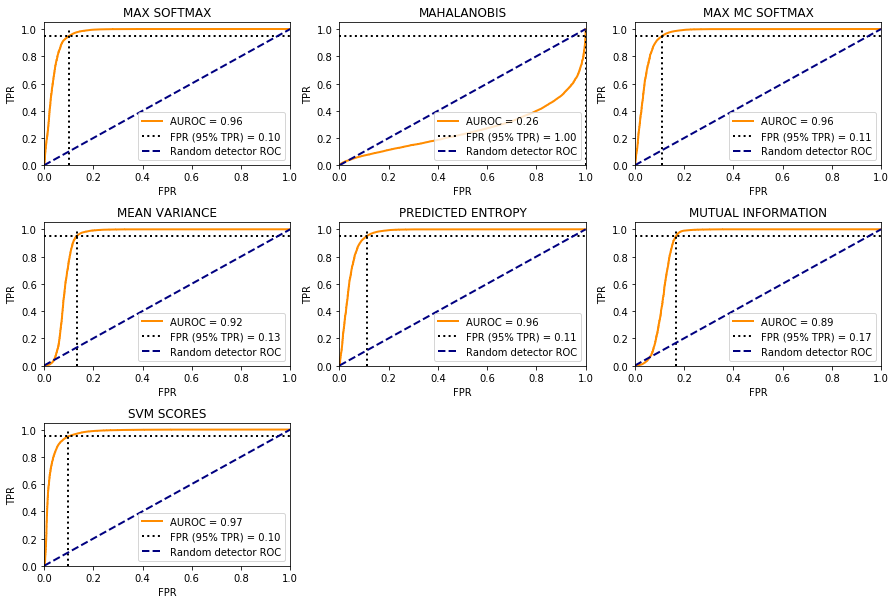

In [49]:
from collections import OrderedDict

scores_dict = OrderedDict({
    "max_softmax": -softmax_outputs.max(axis=1),
    "mahalanobis": -np.array(mahalanobis_dist),
    "max_mc_softmax": -np.max(np.mean(mc_softmax_outputs, axis=0), axis=1),
    "mean_variance": np.mean(mc.variance(mc_softmax_outputs), axis=1),
    "predicted_entropy": mc.predicted_entropy(mc_softmax_outputs),
    "mutual_information": mc.mutual_information(mc_softmax_outputs),
    "svm_scores": -svm_scores
})

plt.figure(figsize=(15,10))

for i, (sk, sv) in enumerate(scores_dict.items()):
    ood_labels = (labels >= NUM_CLASSES).astype(np.int)
    
    fpr, tpr, _ = roc_curve(ood_labels, sv)
    tpr95 = fpr_at_95_tpr(sv, ood_labels)
    roc_auc = auroc(sv, ood_labels)

    plt.subplot(331+i)

    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='AUROC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0.95, 0.95], color='black', lw=lw, linestyle=':', label='FPR (95%% TPR) = %0.2f' % tpr95)
    plt.plot([tpr95, tpr95], [0, 1], color='black', lw=lw, linestyle=':')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random detector ROC')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(sk.replace("_", " ").upper())
    plt.legend(loc="lower right")

plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

In [ ]:
class InputPerturbation(nn.Module):
    def __init__(self, model):
        super().__init__()
        
    